In [66]:
import SimpleITK as sitk
import numpy as np
import matplotlib.pyplot as plt

In [14]:
preopImage = sitk.ReadImage("preopDrrImage.mha", sitk.sitkFloat32)
intraopImage = sitk.ReadImage("pacient09IntraOpDrr.mha", sitk.sitkFloat32)

intraopImageInverted = sitk.InvertIntensity(intraopImage, maximum=1)
preopImage.GetSize(), intraopImage.GetSize()

((1000, 1000, 1), (1000, 1000))

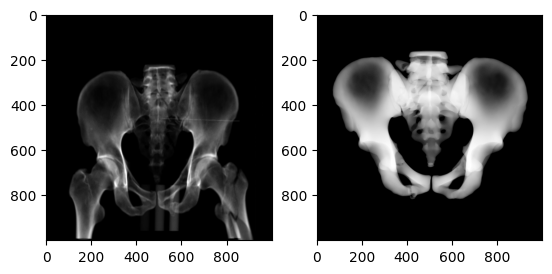

In [15]:
fig2, ax1 = plt.subplots(1, 2)
ax1[0].imshow(sitk.GetArrayViewFromImage(preopImage)[0, ...], cmap="gray")
ax1[1].imshow(sitk.GetArrayViewFromImage(intraopImageInverted), cmap="gray")

Fixed image, spacing: (1.0, 1.0), size: (1000, 1000), direction: (1.0, 0.0, 0.0, 1.0), origin: (0.0, 0.0)
Moving image, spacing: (1.0, 1.0), size: (1000, 1000), direction: (1.0, 0.0, 0.0, 1.0), origin: (0.0, 0.0)


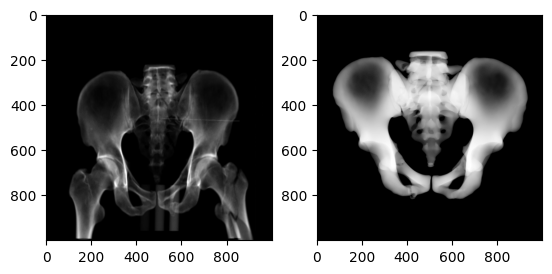

In [57]:
fixedImage = intraopImageInverted
movingImage = preopImage[:, :, 0]
movingImage.SetOrigin(fixedImage.GetOrigin())
movingImage.SetSpacing(fixedImage.GetSpacing())
print(f"Fixed image, spacing: {fixedImage.GetSpacing()}, size: {fixedImage.GetSize()}, direction: {fixedImage.GetDirection()}, origin: {fixedImage.GetOrigin()}")
print(f"Moving image, spacing: {movingImage.GetSpacing()}, size: {movingImage.GetSize()}, direction: {movingImage.GetDirection()}, origin: {movingImage.GetOrigin()}")
fig2, ax2 = plt.subplots(1, 2)
ax2[0].imshow(sitk.GetArrayViewFromImage(preopImage)[0, ...], cmap="gray")
ax2[1].imshow(sitk.GetArrayViewFromImage(intraopImageInverted), cmap="gray")

In [62]:
initialTransform = sitk.CenteredTransformInitializer(fixedImage, movingImage,
                                                     sitk.Euler2DTransform())
registration = sitk.ImageRegistrationMethod()
registration.SetMetricAsMeanSquares()
registration.SetOptimizerAsGradientDescent(learningRate=1.0,
                                           numberOfIterations=200,
                                           convergenceMinimumValue=1e-5,
                                           convergenceWindowSize=5)
registration.SetInitialTransform(initialTransform)
registration.SetInterpolator(sitk.sitkLinear)

In [63]:
outTransform = registration.Execute(fixedImage, movingImage)
print("-------")
print(outTransform)
print(f"Optimizer stop condition: {registration.GetOptimizerStopConditionDescription()}")
print(f" Iteration: {registration.GetOptimizerIteration()}")
print(f" Metric value: {registration.GetMetricValue()}")

-------
itk::simple::Transform
 Euler2DTransform (0000012119A7D540)
   RTTI typeinfo:   class itk::Euler2DTransform<double>
   Reference Count: 3
   Modified Time: 9032
   Debug: Off
   Object Name: 
   Observers: 
     none
   Matrix: 
     0.776129 -0.630575 
     0.630575 0.776129 
   Offset: [409.05, -6980.45]
   Center: [499.39, 454.559]
   Translation: [10.6175, -6767.31]
   Inverse: 
     0.776129 0.630575 
     -0.630575 0.776129 
   Singular: 0
   Angle       = -2.61507e+06

Optimizer stop condition: GradientDescentOptimizerv4Template: Convergence checker passed at iteration 4.
 Iteration: 4
 Metric value: 1.7976931348623157e+308


In [64]:
resampler = sitk.ResampleImageFilter()
resampler.SetReferenceImage(fixedImage)
resampler.SetInterpolator(sitk.sitkLinear)
resampler.SetDefaultPixelValue(1)
resampler.SetTransform(outTransform)

resampledImage = resampler.Execute(movingImage)

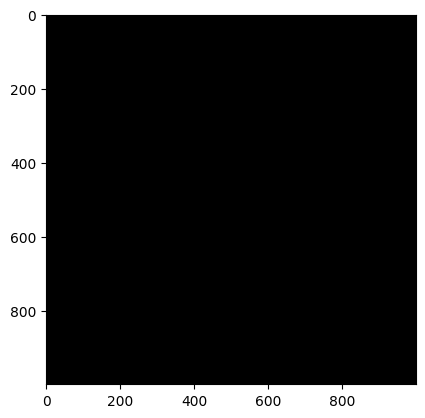

In [65]:
plt.imshow(sitk.GetArrayViewFromImage(resampledImage), cmap="gray")

In [76]:
elastixImageFilter = sitk.ElastixImageFilter()
elastixImageFilter.SetFixedImage(fixedImage)
elastixImageFilter.SetMovingImage(movingImage)
elastixImageFilter.SetParameterMap(sitk.GetDefaultParameterMap("affine"))
out = elastixImageFilter.Execute()

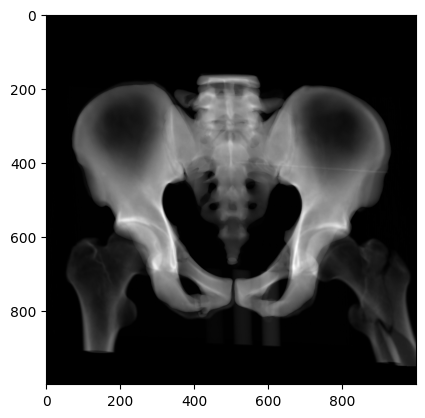

In [77]:
plt.imshow(sitk.GetArrayViewFromImage(out), cmap="gray")
plt.imshow(sitk.GetArrayViewFromImage(fixedImage), cmap="gray", alpha=0.5)

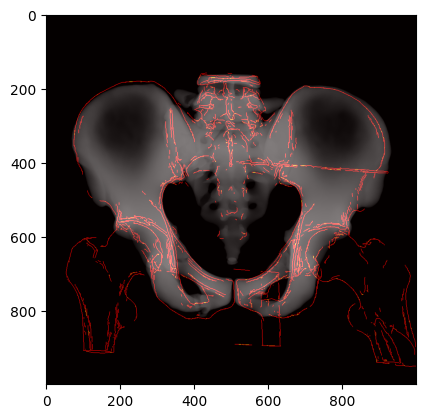

In [96]:
sitkImageEdges = sitk.CannyEdgeDetection(out, lowerThreshold=600, upperThreshold=700)
plt.imshow(sitk.GetArrayViewFromImage(fixedImage), cmap="gray")
plt.imshow(sitk.GetArrayViewFromImage(sitkImageEdges), cmap="hot", alpha=0.5)